# Классификация жанров музыки с помощью Dense и Conv слоев

## Import

In [0]:
# Импорт общих библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [0]:
# импорт специальных библиотек
import librosa
import zipfile
import io
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Импорт sklearn
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [4]:
# Импорт keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM

Using TensorFlow backend.


In [0]:
from google.colab import files
# Подключаем Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Загружаем даные

In [6]:
# Выводим список файлов в папке
file_list = drive.ListFile({'q': "'1O0904TAmmGqhUljJOU6Leg4lPjFIUrhC' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: 012_hw_Sokolov_Dense_Conv_audio.ipynb, id: 1-DFT3rTiblBYpKEiLFFqQxSMBeavpCIc
title: genres (1).zip, id: 12xZQ2DblE3tOxLjlir1KhJGOuEFegHwn
title: Copy of Июльский курс. Занятие 8. Аудио. Классификация жанров музыки, id: 18UKlllloo9WV5340BOjtKjGMK2wN9gD6
title: Copy of Июльский курс. Занятие 8. Аудио. Параметризация аудио, id: 1RPd4WGDWdsE96_bAxnrIv0j5QLEoXpWx
title: Copy of Июльский курс. Занятие 8. Аудио. Классификация жанров музыки. Шаблон ноутбука для домашнего задания, id: 198ZAJb2FO4cfUqSQQiROWfiEb2lgC-cz


In [0]:
train_downloaded = drive.CreateFile({'id': '12xZQ2DblE3tOxLjlir1KhJGOuEFegHwn'})
train_downloaded.GetContentFile('genres (1).zip')

In [8]:
!ls

 adc.json  'genres (1).zip'   sample_data


In [9]:
# Разархивируем архив
z = zipfile.ZipFile('genres (1).zip', 'r')
z.extractall() # В скобках можно прописать path*
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
!ls genres 
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

## Фичи - extraction

In [0]:
# Фичи экстракшн
def get_features(y, sr):

  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
  rmse = np.mean(librosa.feature.rmse(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  # Добавляем фичи в лист
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  for e in mfcc:
    out.append(np.mean(e)) # для mfcc  добавляем среднее
  
  return out

In [11]:
# X и Y train
Y_train = []
X_train = []

for i in range(len(genres)):
  g = genres[i]
  
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    
    X_train.append(out)
    Y_train.append(utils.to_categorical(i, len(genres)))
  print("Жанр", g, "готов")

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов
Жанр classical готов
Жанр country готов
Жанр disco готов
Жанр hiphop готов
Жанр jazz готов
Жанр metal готов
Жанр pop готов
Жанр reggae готов
Жанр rock готов


In [0]:
# Делаем копии
X_train_backup = X_train.copy()
Y_yrain_backup = Y_train.copy()

In [13]:
# Выводим номера классов
y_train_class = np.argmax(Y_train, axis = 1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [14]:
# выводим размерность
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


## Препроцессинг

In [0]:
# Стандартизируем данные X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(X_train, dtype = float))

In [0]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size = 0.15)

## Создаем модели и компилируем их






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 850 samples, validate on 150 samples
Epoch 1/300





850/850 [==============================] - 5s 6ms/step - loss: 1.7963 - acc: 0.3376 - val_loss: 1.5600 - val_acc: 0.4667
Epoch 2/300
850/850 [==============================] - 0s 338us/step - loss: 1.4539 - acc: 0.4847 - val_loss: 1.3850 - val_acc: 0.5533
Epoch 3/300
850/850 [==============================] - 0s 335us/step - loss: 1.3321 - acc: 0.5376 - val_loss: 1.3222 - val_acc: 0.5733
Epoch 4/300
850/850 [==============================] - 0s 328us/step - loss: 1.2623 - acc: 0.5706 - val_loss: 1.2741 - val_acc: 0.6067
Epoch 5/300
850/850 [==============================] - 0s 331us/step - loss: 1.1959 - acc: 0.6059 - val_loss: 1.2431 - val_acc: 0.6133
Epoch 6/300
850/850 [==============================] - 0s 335us/step - loss: 1.1462 - acc: 0.6059 - val_loss: 1.1905 - val_acc: 0.6333
Epoch 7/300
850/850 [==================

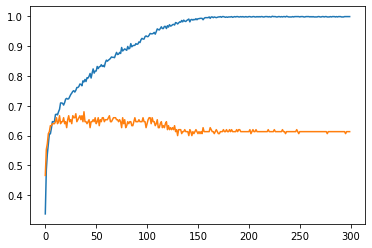

In [17]:
# Создаем модель и компилируем
indexes = range(0,26)

model = Sequential()
model.add(Dense(1024, activation = 'elu', input_shape=(len(indexes),)))
BatchNormalization()
model.add(Dense(1024, activation = 'elu'))
#model.add(Dense(128, activation = 'elu'))
#model.add(Dense(64, activation = 'elu'))
#Dropout(0,1)

model.add(Dense(33, activation = 'elu'))
#Dropout(0,1)
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer=Adam(lr=7e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=300,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))
#                   validation_data = (X_test[:, indexes], y_test))



plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

**Судя по графику - переобучение?**

In [18]:
# Смотрим максимальную точность
max(history.history['val_acc'])

0.6799999872843424

Train on 850 samples, validate on 150 samples
Epoch 1/200
850/850 [==============================] - 1s 1ms/step - loss: 1.7016 - acc: 0.3741 - val_loss: 1.4661 - val_acc: 0.4733
Epoch 2/200
850/850 [==============================] - 0s 420us/step - loss: 1.3464 - acc: 0.5400 - val_loss: 1.2727 - val_acc: 0.5800
Epoch 3/200
850/850 [==============================] - 0s 410us/step - loss: 1.2290 - acc: 0.5729 - val_loss: 1.1736 - val_acc: 0.6400
Epoch 4/200
850/850 [==============================] - 0s 399us/step - loss: 1.1413 - acc: 0.6165 - val_loss: 1.1431 - val_acc: 0.6400
Epoch 5/200
850/850 [==============================] - 0s 415us/step - loss: 1.0726 - acc: 0.6459 - val_loss: 1.0964 - val_acc: 0.6667
Epoch 6/200
850/850 [==============================] - 0s 411us/step - loss: 1.0331 - acc: 0.6424 - val_loss: 1.0696 - val_acc: 0.6733
Epoch 7/200
850/850 [==============================] - 0s 413us/step - loss: 0.9719 - acc: 0.6824 - val_loss: 1.0903 - val_acc: 0.6333
Epoch 8/200

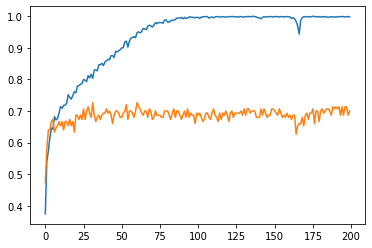

In [19]:
# Создаем и компилируем модель

indexes = [0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,20,21,22,23,24]

model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(1024, activation='elu'))
model.add(Dense(512, activation='elu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

**Переобучения не наблюдается**

In [20]:
# Смотрим максимальную точнусть
max(history.history['val_acc'])

0.7266666650772095